In [158]:
#my imported libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import zipfile #since my dataset is in a zip file
import os
np.random.seed(42)
tf.random.set_seed(42)

['gallina', 'ragno', 'gatto', 'farfalla', 'mucca', 'cavallo', 'cane', 'pecora', 'scoiattolo', 'elefante']


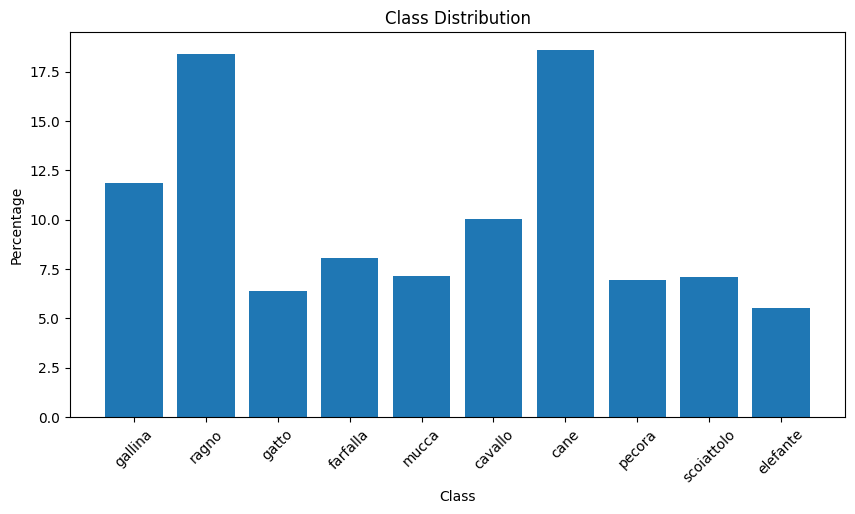

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
Sample batch shape: (64, 224, 224, 3)
Sample labels: [4. 1. 0. 7. 0. 8. 3. 8. 4. 0. 4. 3. 9. 4. 3. 4. 1. 9. 6. 9. 3. 6. 0. 0.
 8. 1. 9. 2. 3. 1. 6. 0. 3. 9. 1. 7. 2. 6. 7. 8. 5. 8. 1. 3. 7. 0. 9. 0.
 7. 7. 6. 4. 8. 8. 1. 8. 1. 8. 0. 5. 9. 0. 7. 0.]


In [170]:
#firstly need to upzip the dataset
with zipfile.ZipFile('/Users/trevordang/Downloads/CECS456-Final/CECS456-Animal-Dataset.zip', 'r') as zip_ref: #need to change directory to match zip file in professor directory
    zip_ref.extractall('animal_images')

#directory where images are unzipped
unzip_dir = '/Users/trevordang/Downloads/CECS456-Final/animal_images/raw-img' #change this directory as well to match professor's directory

print(os.listdir(unzip_dir)) #prints out the structure of the unzipped directories

#counts the number of images in each class directory under zip file
class_counts = {}
total_images = 0
for class_name in os.listdir(unzip_dir):
    class_dir = os.path.join(unzip_dir, class_name)
    if os.path.isdir(class_dir):
        count = len(os.listdir(class_dir))
        class_counts[class_name] = count
        total_images += count

# calculates the percentage of each class proportional to the toal number of images
class_percentages = {class_name: (count / total_images) * 100 for class_name, count in class_counts.items()}

# plotting to help visualize frequency percentage of classes in whole dataset
plt.figure(figsize=(10, 5))
plt.bar(class_percentages.keys(), class_percentages.values())
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

#image autmentation to be used as input for ResNet50 architecture
training_datagenerator = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.2) #validation_split leaves 20% of training dataset to validation dataset
testing_datagenerator = ImageDataGenerator()

#used to load the data from the directory on my computer and augment the training images in batches
training_generator = training_datagenerator.flow_from_directory( #flow_from_directory used because images are already in file structure where images are classified in folders
    unzip_dir, #the directory
    target_size=(224,224), #resizes images to 224x224
    batch_size=64, #batch size 2^4
    class_mode='sparse', #labels are turned into integers for easier classification 
    subset='training' #specifies that this subset is training
)

#same thing as above but now for validation images
validation_generator = training_datagenerator.flow_from_directory(
    unzip_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode='sparse',
    subset='validation' #sets this subset to validation
)

#testing the image data generators
x_sample, y_sample = next(training_generator)
print("Sample batch shape:", x_sample.shape)
print("Sample labels:", y_sample) #prints out the batch of images and labels

In [160]:
#now to create the CNN Deep Learning Model using transfer learning with Resnet50
res_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet') 
res_model.trainable = False  # freeze the convolutional base

#unfreezes the last few layers to allow weights to be trained and updated
for layer in res_model.layers[-3:]:
    layer.trainable = True
    
# Add custom layers on top of ResNet
model = Sequential([
    InputLayer(input_shape=(224, 224, 3)), #just an input layer that specifies shape required
    res_model,
    GlobalAveragePooling2D(), #reduces feature map to one value
    Dense(128, activation='relu'), 
    Dropout(0.5), #prevent overfitting by reducing neurons and for regularization
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  #10 classes, uses softmax for multiclass classification
])

In [161]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 275,274 (1.05 MB)

 Non-trainable params: 23,583,616 (89.96 MB)

In [162]:
#compiles the model with the loss function, optimizer, and takes into account the metric of accuracy
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [163]:
#trains the model on 10 epochs and calculates the accuracy and loss
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.6118 - loss: 1.1675 - val_accuracy: 0.9583 - val_loss: 0.1414
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.9012 - loss: 0.3262 - val_accuracy: 0.9578 - val_loss: 0.1420
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.9291 - loss: 0.2511 - val_accuracy: 0.9606 - val_loss: 0.1344
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.9359 - loss: 0.2278 - val_accuracy: 0.9597 - val_loss: 0.1505
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.9434 - loss: 0.1951 - val_accuracy: 0.9608 - val_loss: 0.1366
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 579s 2s/step - accuracy: 0.9503 - loss: 0.1848 - val_accuracy: 0.9622 - val_loss: 0.1252
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.9545 - loss: 0.1611 - val_accuracy: 0.9648 - val_loss: 0.1244
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.9570 - loss: 0.1506 - val_accu

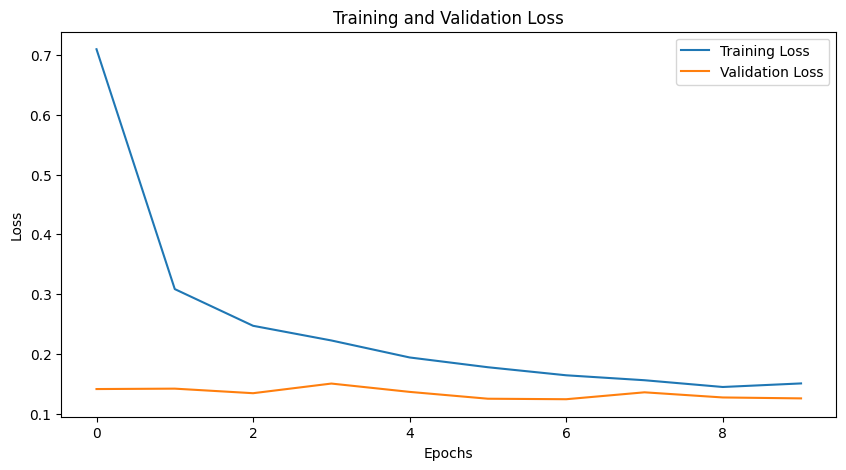

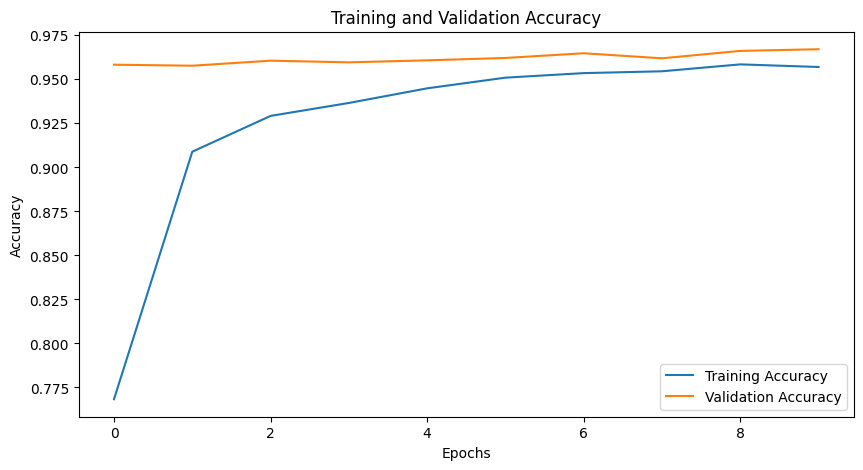

In [167]:
#plotting training and validation loss to ensure trend is correctly displaying loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#plotting training and validation accuracy to ensure trend is correctly displaying accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [164]:
#evaluation of the model and prints out the loss and accuracy
scores = model.evaluate(validation_generator)
print('Loss:', scores[0])
print('Accuracy:', scores[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9658 - loss: 0.1230
Loss: 0.125918447971344
Accuracy: 0.9671253561973572


Found 26179 images belonging to 10 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


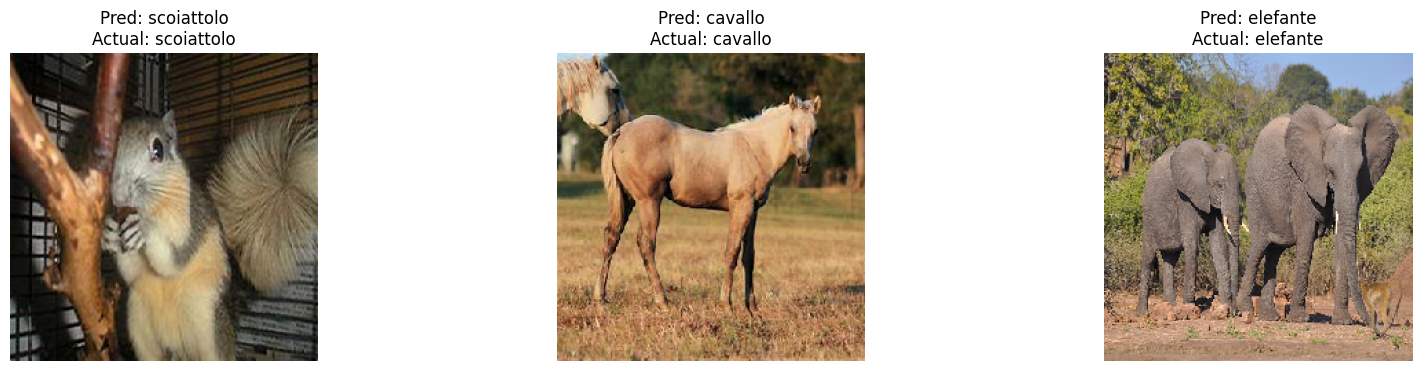

In [173]:
#provides test data to test prediction and final performance
test_generator = testing_datagenerator.flow_from_directory(
    unzip_dir, target_size=(224, 224), batch_size=10, class_mode='sparse', shuffle=True) 

#loads a batch of images for prediction and display
X_display, y_true = next(test_generator)

#preprocess the images for prediction
X_predict = preprocess_input(X_display.copy())

#gets predictions
y_prob = model.predict(X_predict)
y_pred = np.argmax(y_probb, axis=-1)

#retrieves class label mappings
label_map = {v: k for k, v in test_generator.class_indices.items()}

# plots the images with predictions and actual labels
plt.figure(figsize=(20, 4))
for i in range(len(X_display)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_display[i].astype('uint8'))
    plt.title(f'Pred: {label_map.get(y_pred[i], "Unknown")}\nActual: {label_map.get(y_true[i], "Unknown")}')
    plt.axis('off')
plt.show()